# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [3]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
from collections import deque  
import math

## 2. INICIALIZAR MEDIAPIPE

In [4]:
# Configuración inicial global
mp_hands = mp.solutions.hands

# Optimizar MediaPipe
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.45,  # Reducir confianza
    min_tracking_confidence=0.45,
    model_complexity=0  # Menor complejidad
)

mp_draw = mp.solutions.drawing_utils

MODEL_PATH = "model_quantized_90_pruebas_2.tflite"
NORMALIZATION_PARAMS_PATH = 'normalization_params_90_pruebas_2.npz'
dataset_dir = "dataset_11_90"
model_path = "gesture_model_me_10_90_pruebas_2.h5"

sequence_length = 90
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

num_camara = 0

## 3. FUNCIONES PRINCIPALES

In [5]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])


## 4. DETECCION DE MANO

In [6]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## 5. RECOLLECION DE DATOS 

In [7]:
def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    #NUEVO Configurar ventana de landmarks
    landmark_window_name = "Landmarks en Tiempo Real"
    cv2.namedWindow(landmark_window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(landmark_window_name, 640, 480)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        #NUEVO Crear canvas para landmarks
        landmark_canvas = np.zeros((480, 640, 3), dtype=np.uint8)  # Canvas negro 640x480

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []

            #NUEVO Dibujar landmarks en el canvas
            for hand_landmarks in results.multi_hand_landmarks:
                # Dibujar en el canvas negro
                mp_draw.draw_landmarks(
                    landmark_canvas,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_draw.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
            
            # Extraer coordenadas para el dataset
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar si solo hay una mano
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)

            # Dibujar en el frame original
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        #NUEVO Mostrar información en ambas ventanas
        info_text = f"Secuencias: {counter}/{num_sequences}"
        cv2.putText(frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(landmark_canvas, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        cv2.imshow("Recolección de Datos", frame)
        #NEUVO
        cv2.imshow(landmark_window_name, landmark_canvas)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## 6. CARGA DE DATOS

In [8]:
def custom_augmentation(sequence):
    """Aumentación 100% en TensorFlow"""
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.05)

    # Convertir explícitamente a float32
    sequence = tf.cast(sequence, tf.float32)
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.05)
    sequence = tf.add(sequence, noise)
    
    # 2. Escalado aleatorio
    scale_factor = tf.random.uniform([], 0.9, 1.1)
    sequence = tf.multiply(sequence, scale_factor)
    
    # 3. Rotación 2D (versión TensorFlow)
    angle = tf.random.uniform([], -15.0, 15.0)  # Grados
    angle_rad = tf.math.divide(angle * math.pi, 180.0)
    
    # Crear matriz de rotación como tensor
    rot_matrix = tf.stack([
        [tf.cos(angle_rad), -tf.sin(angle_rad), 0.0],
        [tf.sin(angle_rad), tf.cos(angle_rad), 0.0],
        [0.0, 0.0, 1.0]
    ])
    
    # Aplicar rotación a cada landmark
    original_shape = tf.shape(sequence)
    sequence = tf.reshape(sequence, [-1, 3])  # [secuencia_length*42, 3]
    sequence = tf.matmul(sequence, rot_matrix)
    sequence = tf.reshape(sequence, original_shape)
    
    # 4. Desplazamiento temporal (versión TensorFlow)
    shift = tf.random.uniform([], -5, 5, dtype=tf.int32)
    sequence = tf.cond(
        tf.random.uniform([]) > 0.5,
        lambda: tf.roll(sequence, shift=shift, axis=0),
        lambda: sequence
    )

    
    return sequence

# Modificar la función create_dataset
def create_dataset(X_data, y_data, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    
    if augment:
        dataset = dataset.map(
            lambda x, y: (custom_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(1000)
    
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
def load_data(augment=True):
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        print(f"Gesto '{gesture}' - secuencias encontradas: {len(sequences)}")
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
            else:
                print(f"Secuencia {seq_file} con forma {sequence.shape} ignorada.")
    
    return np.array(X, dtype=np.float32), np.array(y), gestures  # Asegurar tipo float32


## 7. ENTRENAMIENTO DEL MODELO

In [10]:
def train_model():
    global X_mean, X_std, gestures
    global NORMALIZATION_PARAMS_PATH, MODEL_PATH
    
    # 1. Verificar datos de entrenamiento
    gestures = get_existing_gestures()
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    # 2. Cargar y preparar datos
    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data(augment=False)  # Cargar sin aumentación inicial
    y = tf.keras.utils.to_categorical(y)

    # 3. Dividir datos antes de crear el Dataset
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 4. Calcular parámetros de normalización
    X_mean = np.mean(X_train, axis=(0, 1)).astype(np.float32)
    X_std = np.std(X_train, axis=(0, 1)).astype(np.float32)
    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std  # Aplicar misma normalización a validación

    train_dataset = create_dataset(X_train, y_train, augment=True)
    val_dataset = create_dataset(X_val, y_val, augment=False)
    

    # 4. Guardar parámetros de normalización
    np.savez(NORMALIZATION_PARAMS_PATH, mean=X_mean, std=X_std)
    
    # 5. Arquitectura optimizada del modelo
    # Modelo CNN + LSTM Bidireccional
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))

    # Primera etapa CNN
    x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)  # Reduce secuencia a la mitad

    # Primera LSTM (retorna secuencia completa)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)

    # Segunda etapa CNN
    x = tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)  # Reduce nuevamente

    # Segunda LSTM (retorna secuencia) + Tercera LSTM (solo último paso)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=False)(x)

    outputs = tf.keras.layers.Dense(len(gestures), activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)


    """Explicación:
    CNN Inicial: Extrae patrones espaciales entre los landmarks en cada paso temporal.
    LSTM Intermedia: Procesa las características extraídas a lo largo del tiempo.
    CNN Profunda: Captura relaciones más complejas en las características temporales.
    LSTM Finales: Modelan dependencias temporales jerárquicas.
    Ventajas vs Opción LSTM Inicial:
    Las CNN actúan como filtros espaciales antes de las LSTM, reduciendo ruido y mejorando la eficiencia.
    Intercalar CNN entre LSTM permite capturar patrones locales en diferentes niveles de abstracción temporal.
    Evita el problema de que las LSTM iniciales procesen datos crudos sin características relevantes.
    Consideraciones:
    Usar return_sequences=True en LSTM intermedias para mantener la secuencia.
    Ajustar padding y MaxPooling para controlar la longitud de la secuencia.
    Si la secuencia es muy corta, eliminar MaxPooling en etapas posteriores."""

    # 6. Compilación y entrenamiento
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()

    print("\nIniciando entrenamiento...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,  # Usar dataset de validación explícito
        epochs=50,
        verbose=1
    )
    # 7. Guardar modelo y resultados
    model.save(model_path)
    print(f"\nModelo guardado en {model_path}")
    
    # 8. Conversión a TFLite con configuraciones especiales
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    try:
        tflite_model = converter.convert()
        with open(MODEL_PATH, 'wb') as f:
            f.write(tflite_model)
        print("\nModelo TFLite exportado exitosamente")
    except Exception as e:
        print(f"\nError en conversión TFLite: {str(e)}")
    
    # Mostrar métricas finales
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

## TF LITE

In [11]:
def convert_to_tflite():
    global MODEL_PATH
    try:
        # Cargar el modelo entrenado
        model = tf.keras.models.load_model(model_path)
        
        # Configurar el conversor con parámetros especiales
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        
        # Añadir estas 3 líneas clave para compatibilidad con LSTM
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False
        converter.allow_custom_ops = True  # Permitir operaciones personalizadas
        
        # Realizar la conversión
        tflite_model = converter.convert()
        
        # Guardar el modelo cuantizado
        with open(MODEL_PATH, 'wb') as f:
            f.write(tflite_model)
            
        print("\n✅ Conversión a TFLite exitosa!")
        
    except Exception as e:
        print(f"\n❌ Error en conversión: {str(e)}")
        print("Posibles soluciones:")
        print("1. Verifique que el modelo .h5 existe")
        print("2. Actualice TensorFlow: pip install --upgrade tensorflow")
        print("3. Reinicie el runtime/kernel")

    global gestures
    gestures = get_existing_gestures()
    print("Gestos cargados para evaluación:", gestures)

    print("Salida del modelo:", model.output_shape)



def representative_dataset_gen():
    # Generador de datos de ejemplo para calibración
    for _ in range(100):
        yield [np.random.randn(1, sequence_length, total_landmarks).astype(np.float32)]

## 8. EVALUACION DEL MODELO

In [12]:
from threading import Thread
# -----------------PROYECTO FINAL - VERSIÓN MEJORADA-----------------
## 8. EVALUACION DEL MODELO (CORRECCIÓN CRÍTICA)
def evaluate():
    global MODEL_PATH, NORMALIZATION_PARAMS_PATH
    global gestures
    gestures = get_existing_gestures()


    if not os.path.exists(MODEL_PATH):
        print("\n¡Primero debe entrenar y convertir el modelo!")
        return
    
    # 1. Cargar parámetros y modelo
    try:
        with np.load('normalization_params_90_pruebas.npz') as data:
            X_mean = data['mean']
            X_std = data['std']
            
        interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        print("Output details shape:", output_details['shape'])
    except Exception as e:
        print(f"\nError crítico: {str(e)}")
        return

    
    # 2. Configuración de cámara
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("\n¡No se puede acceder a la cámara!")
        return

    # 3. Variables de estado mejoradas
    sequence = deque(maxlen=sequence_length)
    prediction_history = deque(maxlen=15)  # Suavizado de predicciones
    current_gesture = "Esperando..."
    current_confidence = 0.0

    # 4. Bucle principal optimizado
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Procesamiento cada 2 frames para mejor rendimiento
        if cv2.waitKey(1) & 0xFF == 27:
            break
        
        # Siempre procesar landmarks (manos detectadas o no)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        landmarks = []
        
        if results.multi_hand_landmarks:
            # Extraer landmarks para ambas manos
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar con ceros si es necesario
            if len(landmarks) < total_landmarks:
                landmarks += [0.0] * (total_landmarks - len(landmarks))
        else:
            # Si no hay manos, usar ceros
            landmarks = [0.0] * total_landmarks
        
        sequence.append(landmarks)
        
        # Realizar predicción cuando la secuencia esté completa
        if len(sequence) == sequence_length:
            try:
                # Preprocesamiento y normalización
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / (X_std + 1e-7)
                input_data = seq_array.reshape(1, sequence_length, total_landmarks).astype(np.float32)

                
                # Durante la evaluación, agregar testeo de forma
                if input_data.shape != tuple(input_details['shape']):
                    print(f"Error: Forma esperada {input_details['shape']}, obtenida {input_data.shape}")
                    return
                
                # Inferencia
                interpreter.set_tensor(input_details['index'], input_data)
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details['index'])[0]
                
                # Procesar resultados con suavizado
                predicted_idx = np.argmax(prediction)
                confidence = prediction[predicted_idx]
                prediction_history.append((predicted_idx, confidence))
                
                # Calcular moda de las últimas predicciones
                most_common = max(prediction_history, key=lambda x: list(prediction_history).count(x))
                final_idx, final_confidence = most_common
                
                if final_confidence > 0.7:
                    current_gesture = gestures[final_idx]
                    current_confidence = final_confidence
                    
            except Exception as e:
                print(f"Error en predicción: {str(e)}")
        
        # Visualización mejorada
        cv2.putText(frame, f"Prediccion: {current_gesture}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
        cv2.putText(frame, f"Confianza: {current_confidence:.2%}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        
        cv2.imshow("Predicciones en Tiempo Real", frame)

    cap.release()
    cv2.destroyAllWindows()

## 9. REENTRENAR GESTO

In [13]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(dataset_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## 10. MENU

In [14]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo, y despues ir a convertir a TFlite")
        print("4. Evaluar")
        print("5. Reentrenar Gesto")
        print("6. Convertir a TFLite")  # Nueva opción
        print("7. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            retrain_gesture()
        elif choice == '6':  # Nueva opción de conversión
            convert_to_tflite()
        elif choice == '7':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU

In [15]:
if __name__ == "__main__":
    main()


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Reentrenar Gesto
6. Convertir a TFLite
7. Salir
Output details shape: [1 7]

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Reentrenar Gesto
6. Convertir a TFLite
7. Salir

¡Hasta luego!


# SALIDA DE ENTRENAMIENTO EXPLICACION

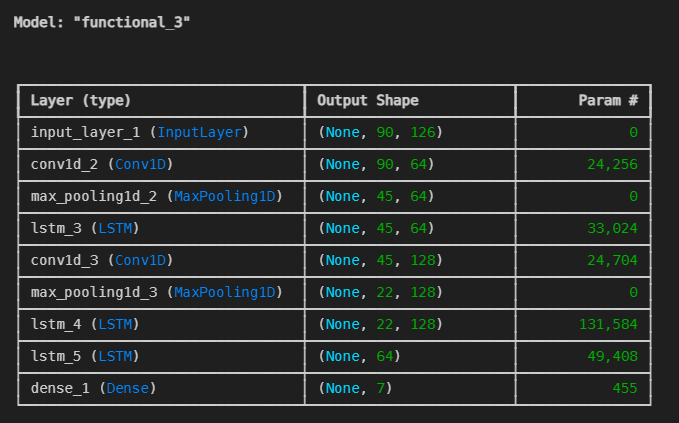
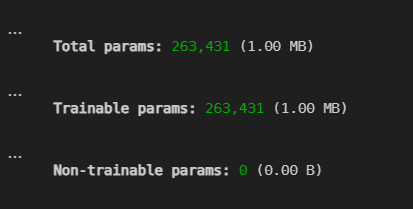

Vamos a analizar el **resumen del modelo** capa por capa, explicando su funcionamiento y cálculos:

---

### **1. Input Layer (Capa de Entrada)**
- **Output Shape:** `(None, 90, 126)`
  - `None`: Batch size (tamaño variable durante el entrenamiento).
  - `90`: Longitud de la secuencia temporal (ej: 90 frames).
  - `126`: Número total de landmarks (ej: 21 landmarks por mano * 3 coordenadas (x,y,z) * 2 manos = 126).
- **Parámetros:** 0 (solo define la forma de entrada).

---

### **2. Conv1D (Primera Capa Convolucional)**
- **Output Shape:** `(None, 90, 64)`
  - Mantiene la longitud temporal (`90`) gracias al `padding='same'`.
  - 64 filtros para extraer patrones locales.
- **Parámetros:** 
  ```python
  (kernel_size * input_channels + 1) * filters = (3*126 + 1)*64 = 24,256
  ```
  - `3`: Tamaño del kernel (ventana temporal).
  - `126`: Canales de entrada (landmarks).
  - `1`: Término de bias por filtro.

---

### **3. MaxPooling1D (Reducción de Secuencia)**
- **Output Shape:** `(None, 45, 64)`
  - Reduce la secuencia a la mitad (`pool_size=2`).
  - Propósito: Extraer características dominantes y reducir dimensionalidad.
- **Parámetros:** 0 (operación de submuestreo).

---

### **4. LSTM (Primera Capa Recurrente)**
- **Output Shape:** `(None, 45, 64)`
  - `return_sequences=True`: Mantiene la secuencia completa para capas posteriores.
  - 64 unidades (neuronas LSTM).
- **Parámetros:** 
  ```python
  4 * ((units + input_dim) * units) = 4 * ((64 + 64) * 64) = 33,024
  ```
  - `4`: Puertas de la LSTM (input, forget, cell, output).
  - `input_dim=64` (de la capa anterior).

---

### **5. Conv1D_1 (Segunda Capa Convolucional)**
- **Output Shape:** `(None, 45, 128)`
  - 128 filtros para patrones más complejos.
- **Parámetros:** 
  ```python
  (3*64 + 1)*128 = 24,704
  ```

---

### **6. MaxPooling1D_1 (Segunda Reducción)**
- **Output Shape:** `(None, 22, 128)`
  - Nueva reducción temporal (de 45 a 22).

---

### **7. LSTM_1 (Segunda Capa Recurrente)**
- **Output Shape:** `(None, 22, 128)`
  - 128 unidades (mayor capacidad de modelado temporal).
- **Parámetros:** 
  ```python
  4 * ((128 + 128) * 128) = 131,584
  ```

---

### **8. LSTM_2 (Tercera Capa Recurrente)**
- **Output Shape:** `(None, 64)`
  - `return_sequences=False`: Solo retorna el último paso temporal.
  - 64 unidades para resumen final de la secuencia.
- **Parámetros:** 
  ```python
  4 * ((128 + 64) * 64) = 49,408
  ```

---

### **9. Dense (Capa de Salida)**
- **Output Shape:** `(None, 7)`
  - 7 neuronas (clases de gestos, `len(gestures)`).
- **Parámetros:** 
  ```python
  (64 * 7) + 7 = 455
  ```
  - Conecta las 64 unidades de entrada a 7 salidas + biases.

---

### **Resumen Total**
- **Parámetros entrenables:** 263,431 (~1 MB).
- **No entrenables:** 0 (sin capas de normalización/freeze).

---

### **Interpretación del Flujo**
1. **CNN Inicial:** Extrae patrones espaciales entre landmarks en cada frame.
2. **LSTM 1:** Modela dependencias temporales cortas.
3. **CNN Profunda:** Detecta patrones jerárquicos en características temporales.
4. **LSTM Finales:** Capturan dependencias a largo plazo y resumen global.

### **Eficiencia vs. Complejidad**
- El modelo es ligero (1MB), ideal para aplicaciones en tiempo real.
- Las CNN reducen la dimensionalidad antes de LSTM, mejorando eficiencia.
- Las 3 LSTM permiten modelar temporalidad a múltiples escalas.

### **Posibles Optimizaciones**
- Añadir `Dropout` entre capas para evitar overfitting.
- Usar `Bidirectional LSTM` si el contexto temporal es bidireccional.
- Aumentar filtros en CNN si se requiere más detalle espacial.

---------------
--------------

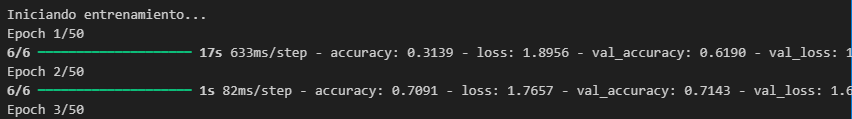

Vamos a desglosar cada elemento de los logs de entrenamiento para que entiendas su significado y utilidad:

---

### **1. `6/6` (Batch Progress)**
- **Qué es:** Indica el progreso de batches por época.
  - Primer `6`: Número de batches procesados en la época actual.
  - Segundo `6`: Total de batches por época.
- **Por qué aparece 6/6:**  
  - Depende del tamaño de tu dataset y el `batch_size`.  
  - **Ejemplo:** Si tienes 120 muestras de entrenamiento y usas `batch_size=20`, se dividirá en 6 batches (120/20 = 6).

---

### **2. `accuracy` (Exactitud de Entrenamiento)**
- **Qué es:** Porcentaje de muestras clasificadas correctamente **en el conjunto de entrenamiento** durante la época.
- **Para qué sirve:**
  - Mide cómo está aprendiendo el modelo con los datos que ve.
  - **Ejemplo:** `accuracy: 0.7329` = 73.29% de acierto en entrenamiento.
- **Cuidado:** Si es muy alto (>95%) pero `val_accuracy` es bajo, hay **sobreajuste (overfitting)**.

---

### **3. `loss` (Pérdida de Entrenamiento)**
- **Qué es:** Valor de la función de pérdida (ej: cross-entropy) **en entrenamiento**.
- **Para qué sirve:**
  - Indica cuánto se equivoca el modelo. Menor valor = mejor.
  - **Ejemplo:** `loss: 1.6447` = Error promedio en predicciones.
- **Relación con accuracy:**  
  - Si `loss` baja y `accuracy` sube → Modelo está aprendiendo bien.  
  - Si `loss` estanca → Problema de aprendizaje (quizás learning rate mal configurado).

---

### **4. `val_accuracy` (Exactitud de Validación)**
- **Qué es:** Porcentaje de aciertos en el **conjunto de validación** (datos no vistos durante el entrenamiento).
- **Para qué sirve:**
  - Evalúa la capacidad del modelo para generalizar.
  - **Ejemplo:** `val_accuracy: 0.7619` = 76.19% de acierto en datos nuevos.
- **Señal clave:**  
  - Si `val_accuracy` es similar a `accuracy` → Modelo generaliza bien.  
  - Si `val_accuracy` << `accuracy` → Overfitting.

---

### **5. `val_loss` (Pérdida de Validación)**
- **Qué es:** Valor de la función de pérdida en el conjunto de validación.
- **Para qué sirve:**
  - Mide el error en datos no vistos. Menor = mejor generalización.
  - **Ejemplo:** `val_loss: 1.5590` = Error en validación.
- **Patrón crítico:**  
  - Si `val_loss` sube mientras `loss` baja → Overfitting grave.

---

### **6. `Xms/step` (Tiempo por Batch)**
- **Qué es:** Tiempo promedio que tarda en procesar un batch.
- **Para qué sirve:**  
  - Estimar duración total del entrenamiento.  
  - **Ejemplo:** `633ms/step` = 0.63 segundos por batch. Con 6 batches/epoch: 6 × 0.63 ≈ 3.8 segundos por época.

---

### **Análisis de tus Resultados**  
Observando tus 3 primeras épocas:  

| Época | Train Accuracy | Val Accuracy | Train Loss | Val Loss  |
|-------|----------------|--------------|------------|-----------|
| 1     | 31.39%         | 61.90%       | 1.8956     | 1.8032    |
| 2     | 70.91%         | 71.43%       | 1.7657     | 1.6839    |
| 3     | 73.29%         | 76.19%       | 1.6447     | 1.5590    |

#### **Tendencias Positivas:**  
1. **Val Accuracy aumenta** (61.9% → 76.19%): El modelo mejora en datos no vistos.  
2. **Val Loss disminuye**: El error en validación se reduce, señal de buena generalización.  
3. **Train Accuracy y Val Accuracy convergen**: No hay overfitting (diferencia < 5%).  

#### **Recomendaciones:**  
- Si `val_accuracy` sigue subiendo después de 50 épocas, el modelo es viable.  
- Si se estanca, prueba:  
  - Aumentar épocas.  
  - Añadir regularización (Dropout, L2).  
  - Incrementar diversidad de datos.

---

### **¿Para qué te sirve todo esto?**  
- **Diagnosticar overfitting/underfitting.**  
- **Decidir cuándo parar el entrenamiento** (usando early stopping).  
- **Ajustar hiperparámetros** (learning rate, arquitectura).  
